In [1]:

%pprint

Pretty printing has been turned OFF


In [129]:

%run ../load_magic/dataframes.py
from urllib.error import HTTPError

tables_url = 'https://colorswall.com/palette/3847/'
try:
    page_tables_list = get_page_tables(tables_url)
except HTTPError as e:
    print(str(e).strip())

[(0, (16, 3))]


In [134]:

import requests

response_obj = requests.get(tables_url)
page_soup = bs(response_obj.text, 'html.parser')

In [144]:

%run ../load_magic/storage.py

s = Storage()
if s.pickle_exists('minecraft_colors_dict'):
    minecraft_colors_dict = s.load_object('minecraft_colors_dict')
else:
    minecraft_colors_dict = {}
    for col_div in page_soup.select('div[class="color-block col"] > div[class="color-info-additional"]'):
        children_list = list(col_div.children)
        color_name = children_list[0].text.strip()
        hex_value = children_list[2].text.strip()
        minecraft_colors_dict[color_name] = hex_value
    s.store_objects(minecraft_colors_dict=minecraft_colors_dict)

Pickling to D:\Documents\GitHub\MineCraft\saves\pickle\minecraft_colors_dict.pickle


In [37]:

import matplotlib.pyplot as plt

# Use the following only if you are on a high definition device
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

In [92]:

import os
from bs4 import BeautifulSoup as bs

def get_minecraft_soup():
    html_dir = '../data/html'
    file_name = 'How_to_obtain_every_dye_color_in_Minecraft_survival_mode.html'
    html_path = os.path.join(html_dir, file_name)
    with open(html_path) as f:
        form_html = f.read()
    page_soup = bs(form_html, 'html.parser')
    
    return page_soup
page_soup = get_minecraft_soup()

In [97]:

import networkx as nx
import re

mixture_regex = re.compile(r'(\d+ (?:Red|Yellow|Green|White|Blue|Purple|Pink|Black|Gray) Dye)(?:, (?:and )?| and )?')
dye_digraph = nx.DiGraph()
dye_list = []
mixture_list = []
for dye_h3 in page_soup.select('h3'):
    dye_list = dye_h3.text.split('|')
    dye_str = dye_list[0].strip()
    dye_list.append(dye_str)
    dye_versatility = dye_list[1].strip()
    dye_digraph.add_node(dye_str, kind=dye_versatility)
    source_list = list(dye_h3.next_siblings)[1].select('li')
    for source_li in source_list:
        source_str = source_li.text.strip()
        dye_digraph.add_node(source_str)
        dye_digraph.add_edge(source_str, dye_str)
        if ' and ' in source_str:
            mixture_list.append(source_str)
            results_list = mixture_regex.findall(source_str)
            for mixture_str in results_list:
                parts_list = mixture_str.split(' ')
                mixture_count = float(parts_list[0])
                dye_color = parts_list[1]
                dye_digraph.add_edge(f'{dye_color} Dye', source_str, mixture_count=mixture_count)

In [94]:

import os

# Export the graph into Gephi
SAVES_FOLDER = '../saves'
gexf_dir = os.path.join(SAVES_FOLDER, 'gexf')
os.makedirs(name=gexf_dir, exist_ok=True)
file_name = 'dye_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)
nx.write_gexf(dye_digraph, file_path)
message_str = '''
1) Launch Gephi
2) In the File menu, open {}
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and save as {}.gdf
6) Repeat 2) through 5) as necessary
'''
print(message_str.format(os.path.abspath(file_path), file_name.split('.')[0]))


1) Launch Gephi
2) In the File menu, open D:\Documents\GitHub\MineCraft\saves\gexf\dye_digraph.gexf
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and save as dye_digraph.gdf
6) Repeat 2) through 5) as necessary



In [167]:

# Get the positional information that you exported from Gephi
import re
import numpy as np

gdf_folder = os.path.join(SAVES_FOLDER, 'gdf')
os.makedirs(name=gdf_folder, exist_ok=True)
file_path = os.path.join(gdf_folder, 'dye_digraph.gdf')

with open(file_path) as f:
    data_str = f.read()
defs_list = data_str.split('edgedef>')
nodedef_str = defs_list[0].strip()

node_strs_list = nodedef_str.split('\n')[1:]
nodedef_regex = re.compile(r"""^([^"\r\n]+),"\1",10\.0,10\.0,([^,]+),([^,]+),'0,0,0',("[^"]+")?""")
layout_dict = {}
for node_str in node_strs_list:
    match_obj = nodedef_regex.search(node_str)
    if match_obj:
        node_name = match_obj.group(1)
        node_x = float(match_obj.group(2))
        node_y = float(match_obj.group(3))
        layout_dict[node_name] = np.array([node_x, node_y])

In [169]:

nodes_list = []
node_colors_list = []
node_sizes_list = []
for node_name, attrs_dict in dict(dye_digraph.nodes(data=True)).items():
    nodes_list.append(node_name)
    if 'kind' in attrs_dict:
        node_colors_list.append(minecraft_colors_dict[node_name[:-4]])
        kind_str = attrs_dict['kind']
        if kind_str == 'Primary':
            node_sizes_list.append(600)
        elif kind_str == 'Secondary':
            node_sizes_list.append(500)
        elif kind_str == 'Versatile':
            node_sizes_list.append(400)
    else:
        node_colors_list.append('#cccccc')
        node_sizes_list.append(300)

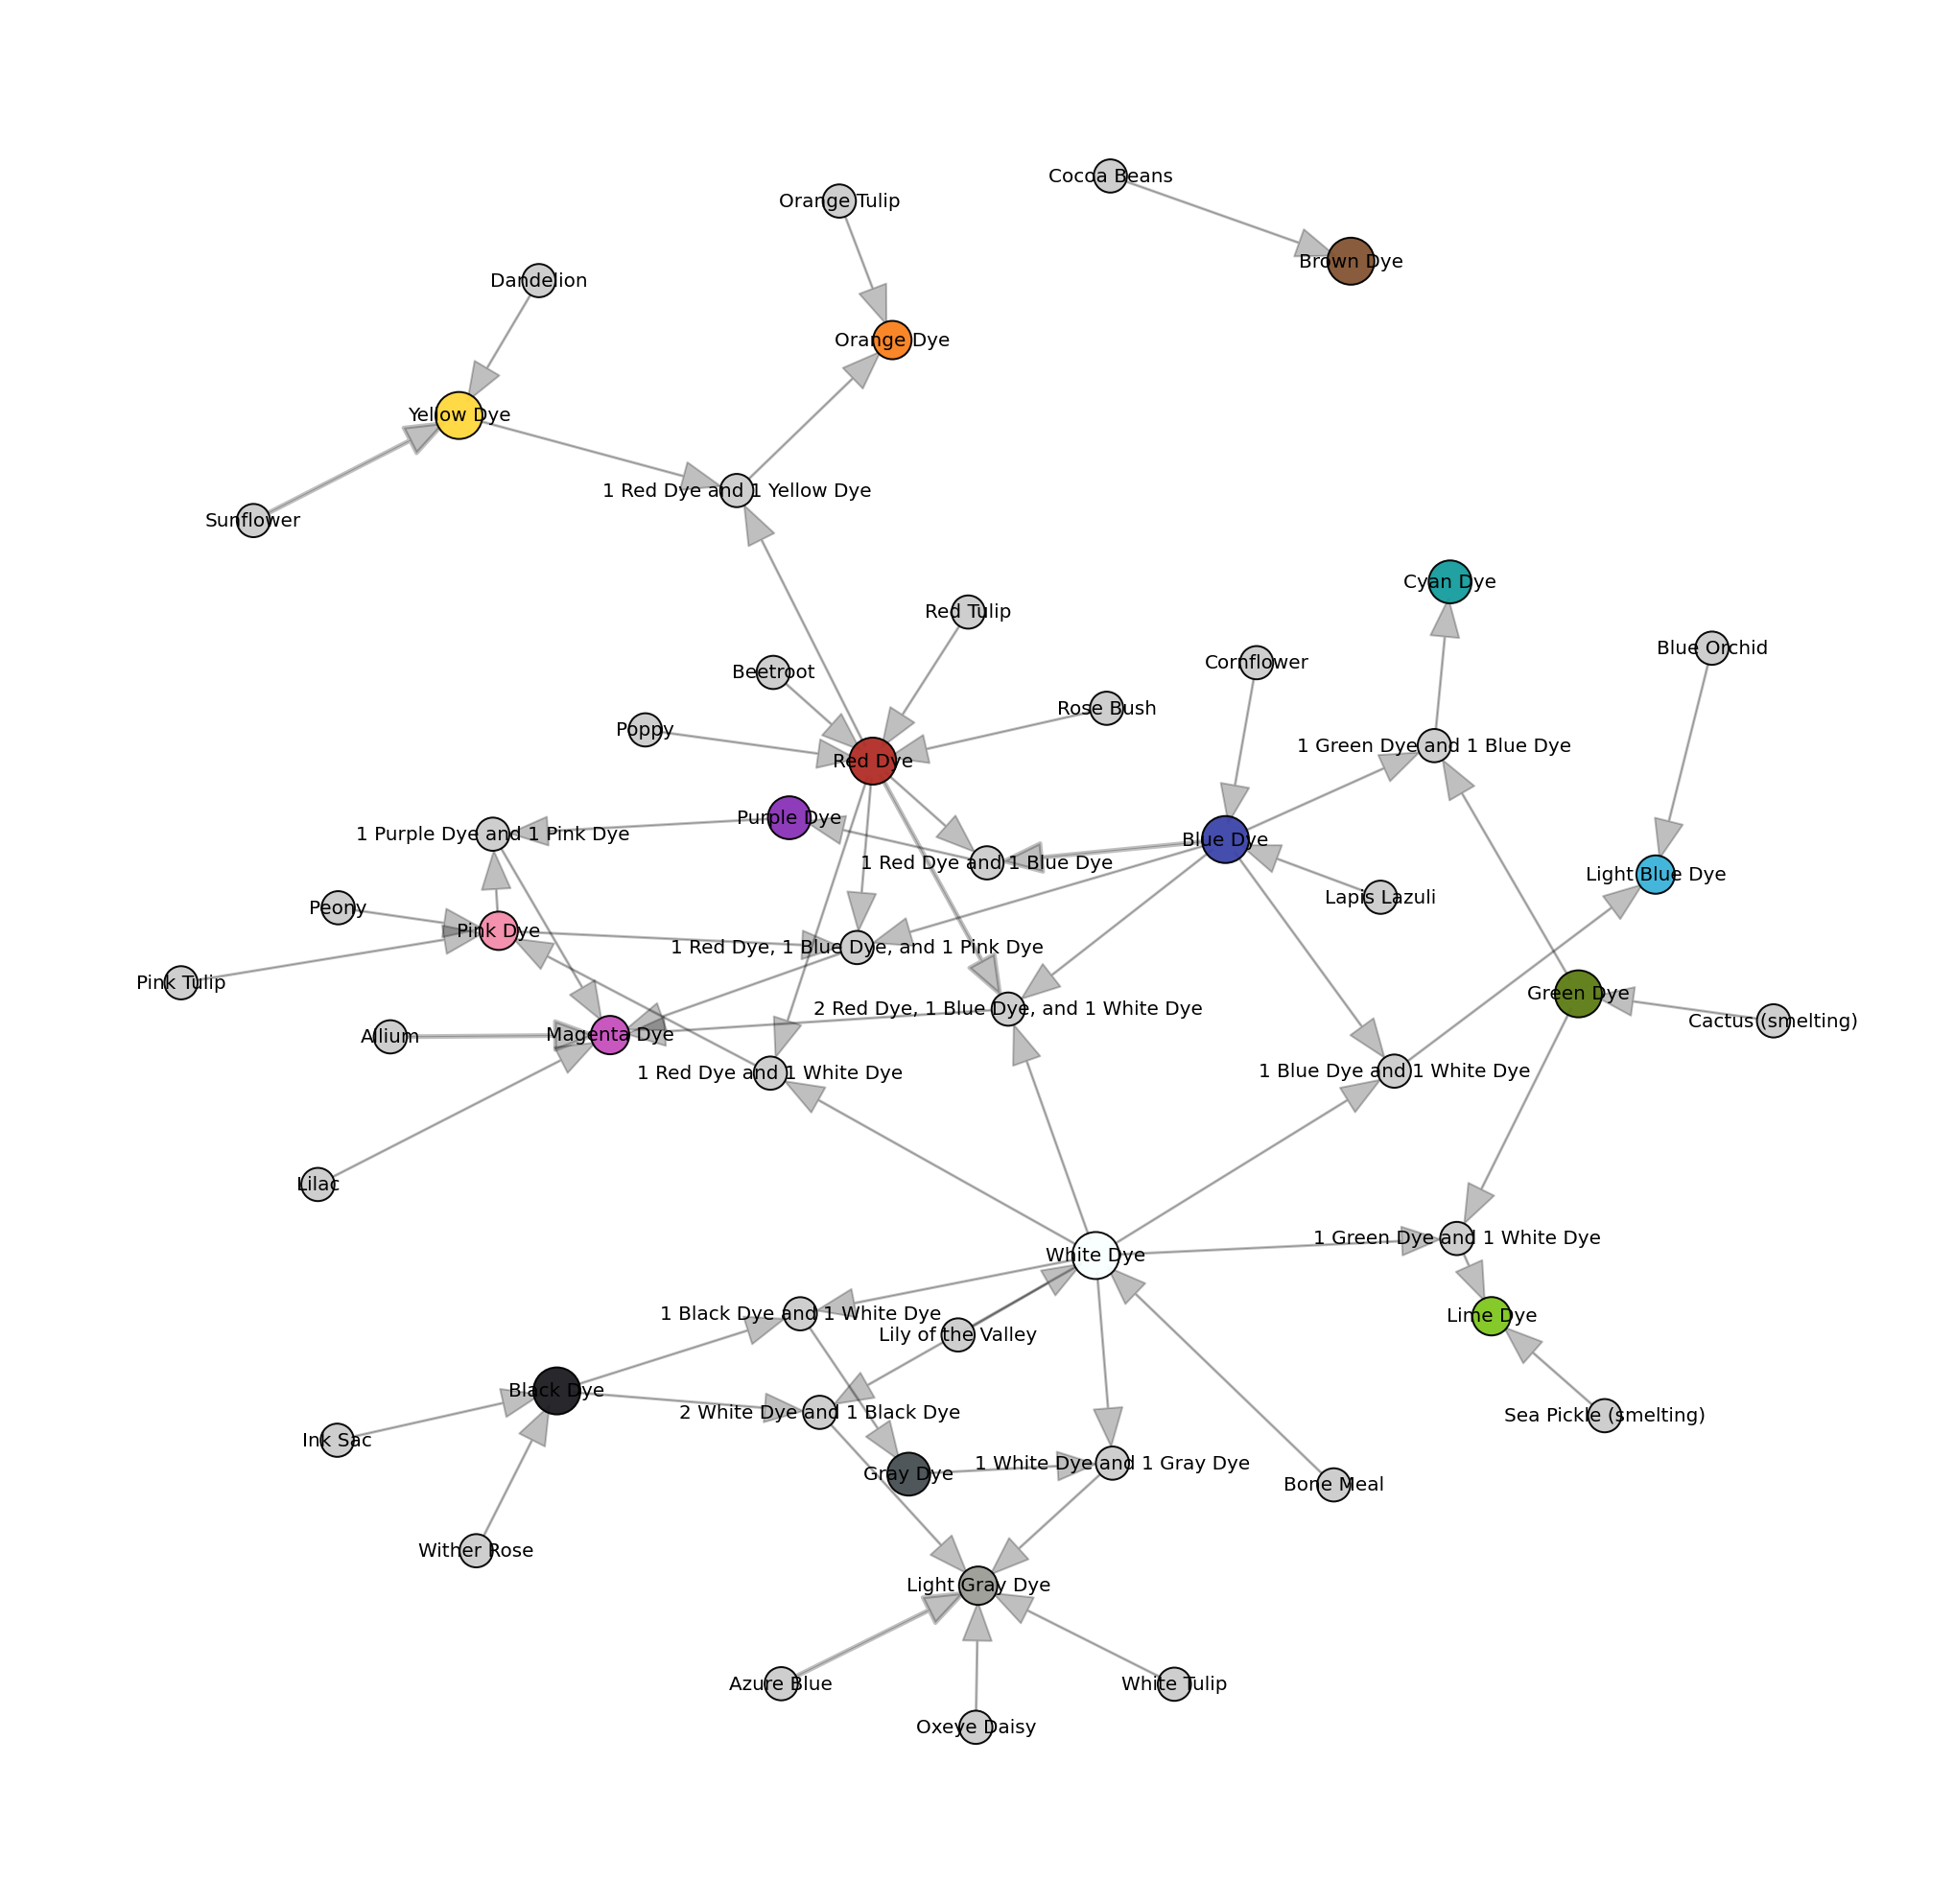

In [170]:

import numpy as np
import matplotlib.patches as mpatches

# Plot the graph using matplotlib
fig = plt.figure(figsize=(18, 18))
plt.axis('off')
plt.yticks([], [])
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)
node_collection = nx.draw_networkx_nodes(dye_digraph, pos=layout_dict, nodelist=nodes_list, node_color=node_colors_list,
                                         edgecolors='#000000', node_size=node_sizes_list, alpha=0.95)
edge_collection = nx.draw_networkx_edges(dye_digraph, pos=layout_dict, alpha=0.25, arrowstyle=arrowstyle,
                                         width=list(nx.get_edge_attributes(dye_digraph, 'mixture_count').values())*2)
labels_collection = nx.draw_networkx_labels(dye_digraph, pos=layout_dict, font_size=10)
# axes_subplot = fig.get_axes()[0]
# xlim_tuple = axes_subplot.set_xlim(left=-1.25, right=1.25)


----

In [5]:

print(['page_soup.{}'.format(fn) for fn in dir(page_soup) if not fn.startswith('_')])

['page_soup.ASCII_SPACES', 'page_soup.DEFAULT_BUILDER_FEATURES', 'page_soup.NO_PARSER_SPECIFIED_WARNING', 'page_soup.ROOT_TAG_NAME', 'page_soup.append', 'page_soup.attrs', 'page_soup.builder', 'page_soup.can_be_empty_element', 'page_soup.cdata_list_attributes', 'page_soup.childGenerator', 'page_soup.children', 'page_soup.clear', 'page_soup.contains_replacement_characters', 'page_soup.contents', 'page_soup.currentTag', 'page_soup.current_data', 'page_soup.declared_html_encoding', 'page_soup.decode', 'page_soup.decode_contents', 'page_soup.decompose', 'page_soup.decomposed', 'page_soup.descendants', 'page_soup.element_classes', 'page_soup.encode', 'page_soup.encode_contents', 'page_soup.endData', 'page_soup.extend', 'page_soup.extract', 'page_soup.fetchNextSiblings', 'page_soup.fetchParents', 'page_soup.fetchPrevious', 'page_soup.fetchPreviousSiblings', 'page_soup.find', 'page_soup.findAll', 'page_soup.findAllNext', 'page_soup.findAllPrevious', 'page_soup.findChild', 'page_soup.findChild

In [24]:

print(['page_soup.{}'.format(fn) for fn in dir(page_soup) if 'next' in fn.lower()])

['page_soup.fetchNextSiblings', 'page_soup.findAllNext', 'page_soup.findNext', 'page_soup.findNextSibling', 'page_soup.findNextSiblings', 'page_soup.find_all_next', 'page_soup.find_next', 'page_soup.find_next_sibling', 'page_soup.find_next_siblings', 'page_soup.next', 'page_soup.nextGenerator', 'page_soup.nextSibling', 'page_soup.nextSiblingGenerator', 'page_soup.next_element', 'page_soup.next_elements', 'page_soup.next_sibling', 'page_soup.next_siblings']


In [12]:

for navigable_str in page_soup.stripped_strings:
    print(navigable_str)

Part of the fun of Minecraft is definitely the building. Creating colorful builds or dying sheep different colors are definitely fun ways to show off your creativity. In creative mode, every dyed block, item, or entity is just a click away, but in survival mode, it takes time to gather every dye in the game. Here is how to acquire all 16 dye colors in Minecraft survival mode.
Note: This guide is optimized for Java Edition. Bedrock Edition is similar enough to use this guide for, but has the following discrepancies
:
Lapis Lazuli instead of Blue Dye, Bone Meal instead of White Dye, and Ink Sacs instead of Black Dye
Obtaining Dyes
There are three different types of dye when it comes to methods on how to get them. Primary dyes mean that they can only be created from a worldly source like a flower, cactus, or Ink Sac. Secondary dyes are only able to be created by mixing two existing dyes together. Versatile dyes, on the other hand, are able to be created by both worldly sources and dye mix